In [1]:
using JITrench

In [2]:
abstract type AbstractPlaceHolder end

In [3]:
struct FunctionPlaceHolder{T, S} <: JITrench.AutoDiff.DiffableFunction
    true_func :: Type{<:JITrench.AutoDiff.DiffableFunction}
    inputs :: T
    output :: S
end

In [4]:
struct ConstantScalarNode <: AbstractPlaceHolder end

In [5]:
mutable struct ScalarPlaceHolder <: AbstractPlaceHolder
    creator::Union{Nothing, JITrench.AutoDiff.DiffableFunction}
    generation::Int
    req_broadcast::Bool
    function ScalarPlaceHolder(; creator=nothing, generation=0, req_broadcast=false)
        new(creator, generation, req_broadcast)
    end
end

In [6]:
function Base.show(io::IO, ::MIME"text/plain", x::ScalarPlaceHolder)
    print(io, "ScalarPlaceHolder($(objectid(x)))\n")
end

function Base.show(io::IO, x::ScalarPlaceHolder)
    print(io, "ScalarPlaceHolder($(objectid(x)))\n")
end

In [7]:
Base.:+(x1::ScalarPlaceHolder, x2::ScalarPlaceHolder) = call!(ScalarPlaceHolder, JITrench.Add, x1, x2)
Base.:+(x1::ScalarPlaceHolder, x2::Real)   = call!(ScalarPlaceHolder, JITrench.Add, x1, ConstantScalarNode())
Base.:+(x1::Real, x2::ScalarPlaceHolder)   = call!(ScalarPlaceHolder, JITrench.Add, ConstantScalarNode(), x2)

In [8]:
function call!(::Type{ScalarPlaceHolder}, F::Type{<:JITrench.AutoDiff.BinaryOperator}, x1::ScalarPlaceHolder, x2::ScalarPlaceHolder)
    inputs = (x1, x2)
    output = ScalarPlaceHolder()
    func = FunctionPlaceHolder(F, inputs, output)
    output.creator = func
    return output
end

call! (generic function with 1 method)

In [9]:
x = ScalarPlaceHolder()
y = ScalarPlaceHolder()

ScalarPlaceHolder(3508123368205643950)


In [10]:
z = x + y

ScalarPlaceHolder(13865672917643005263)


In [11]:
z.creator

FunctionPlaceHolder{Tuple{ScalarPlaceHolder, ScalarPlaceHolder}, ScalarPlaceHolder}

In [12]:
const tmp_dir = joinpath(expanduser("~"), ".JITrench")
const dot_file_path = joinpath(tmp_dir, "tmp_graph.dot")

"/Users/yuchi_ymgc/.JITrench/tmp_graph.dot"

In [13]:
colors = Dict("func" => "lightblue", "var" => "orange", "user_defined_var" => "orange")
shapes = Dict("var" => "ellipse", "user_defined_var" => "polygon, sides=8")

Dict{String, String} with 2 entries:
  "user_defined_var" => "polygon, sides=8"
  "var"              => "ellipse"

In [14]:
struct PNGContainer
    content
end

In [15]:
function Base.show(io::IO, ::MIME"image/png", c::PNGContainer)
    write(io, c.content)
end

In [16]:
function _dot_var(var::ScalarPlaceHolder)
    if var.creator === nothing
        color = colors["user_defined_var"]
        shape = shapes["user_defined_var"]
    else
        color = colors["var"]
        shape = shapes["var"]
    end

    return "$(objectid(var)) [shape=$shape, label=\"ScalarPlaceHolder\", color=\"$color\", style=filled]\n"
end

_dot_var (generic function with 1 method)

In [17]:
function _dot_func(f::FunctionPlaceHolder)
    f_type = f.true_func
    f_name = split(split(repr(f_type), ".")[end], "{")[begin]
    txt = "$(objectid(f)) [label=\"$(f_name)\", color=\"$(colors["func"])\", style=filled, shape=box]\n"
    for x in f.inputs
        txt *= "$(objectid(x)) -> $(objectid(f))\n"
    end
    txt *= "$(objectid(f)) -> $(objectid(f.output))\n"
    return txt
end

_dot_func (generic function with 1 method)

In [18]:
function get_dot_graph(var, title)
    txt = ""
    funcs = []
    seen_set = Set{}()
    push!(funcs, var.creator)
    txt = _dot_var(var)
    while !(isempty(funcs))
        f = pop!(funcs)
        txt *= _dot_func(f)
        # TODO: avoid conditional branching by type
        if f isa AutoDiff.BroadcastWrapper
            for x in f.wrapped_func.grad_field.inputs
                txt *= _dot_var(x)
                if x.creator !== nothing && (!(x.creator in seen_set))
                    push!(seen_set, x.creator)
                    push!(funcs, x.creator)
                end
            end
        else
            for x in f.inputs
                txt *= _dot_var(x)
                if x.creator !== nothing && (!(x.creator in seen_set))
                    push!(seen_set, x.creator)
                    push!(funcs, x.creator)
                end
            end
        end
    end
    return "digraph g {
            graph [
                labelloc=\"t\";
                label= \"$(title)\"
            ];
                $txt 
            }"
end

get_dot_graph (generic function with 1 method)

In [19]:
function plot_tmp_dir()
    extension = "png"
    to_file = joinpath(tmp_dir, "graph." * extension)
    cmd = `dot $(dot_file_path) -T $(extension) -o $(to_file)`
    run(cmd)
    return to_file
end

plot_tmp_dir (generic function with 1 method)

In [20]:
function plot_graph(var; to_file = "", title = "")
    dot_graph = get_dot_graph(var, title)

    # make tmp directory to contain .dot 
    (!(ispath(tmp_dir))) && (mkdir(tmp_dir))

    open(dot_file_path, "w") do io
        write(io, dot_graph)
    end

    if to_file == ""
        # plot tmp directory 
        png_file_path = plot_tmp_dir()
        # read and display it by using `PNGContainer`
        c = open(png_file_path) do io
            PNGContainer(read(io))
        end
        return c
    else
        extension = split(to_file, ".")[end]
        cmd = `dot $(dot_file_path) -T $(extension) -o $(to_file)`
        run(cmd)
    end
end

plot_graph (generic function with 1 method)

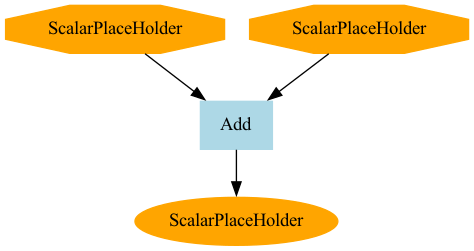

In [21]:
plot_graph(z)